In [1]:
%matplotlib inline

# Getting Started With DESC

DESC is a 3D MHD equilibrium and optimization code suite, which solves the ideal MHD equilibrium equations to find stellarator equilibria. 

Like VMEC, DESC requires 4 main inputs to define the equilibrium problem:

 - Pressure Profile
 - Rotational Transform Profile
 - Last Closed Flux Surface Boundary Shape
 - Total toroidal magnetic flux enclosed by the LCFS

DESC can be run both with a text input file from the command line (e.g. `python -m desc INPUT_FILE`) or through python scripts (which offers more options than the text file for equilibrium solving and optimization). This tutorial notebook will focus on running from the command line.

## Installing DESC

The installation instructions are located in the [installation documentation page](https://desc-docs.readthedocs.io/en/latest/installation.html#installation).

Once these instructions are followed and DESC is installed correctly, you should be able to a module from desc such as `import desc.equilibrium` without any errors.

In [2]:
import desc.equilibrium

DESC version 0.5.0+90.ge05f3d5.dirty, using JAX backend, jax version=0.2.25, jaxlib version=0.1.76, dtype=float64
Using device: CPU, with 21.14 GB available memory


## Running DESC On HELIOTRON Example Case

We will now see how to run DESC on the HELIOTRON example case.

We could run this from a DESC input file directly, but we will first show how you can convert a VMEC input file to a DESC input file.

In this directory is a VMEC input file titled `input.HELIOTRON` which contains a finite beta HELIOTRON fixed boundary stellarator. To convert we can simply run DESC from the command line directly on the VMEC input file with one of the following commands:



if you've pip installed DESC 

or


if the DESC repo is cloned and in your PYTHONPATH but not pip installed.

The `-vv` flag is just for verbosity, and the `-o` flag allows us to specify the name of the output HDF5 file (the default name is `XXX_output.h5`). See the [command line docs](https://desc-docs.readthedocs.io/en/latest/command_line.html#command-line-interface) for more information.

This will automatically convert the VMEC input file to a DESC input file (named by default `input.HELIOTRON_desc`), and then run DESC with that input file. However, there are many DESC solver options which do not have analogs in VMEC, and so this automatic conversion may not result in a great solution. It is then recommended to modify the solver options to allow for a better convergence to an equilibrium solution. The DESC input files are [documented here](https://desc-docs.readthedocs.io/en/latest/input.html#input-file).

As a general rule, the most important parameters to change are related to the spectral resolution and the continuation method parameters. DESC leverages a multi-grid continuation method to allow for more robust convergence of highly shaped equilibria, and this is controlled by the following parameters:

 **Spectral Resolution**
 
 - ` L_rad` (int): Maximum radial mode number for the Fourier-Zernike basis, . Default = `M_pol` if `spectral_indexing = ANSI`, or `2*M_pol` if `spectral_indexing = Fringe`. For more information see [Basis functions and collocation nodes](https://desc-docs.readthedocs.io/en/latest/notebooks/basis_grid.html).
 - `M_pol` (int): Maximum poloidal mode number for the Fourier-Zernike basis, . **Required Input**.
 - `N_tor` (int): Maximum toroidal mode number for the Fourier-Zernike basis, . Default = 0.
 - `L_grid` (int): Radial resolution of nodes in collocation grid. Default = `M_grid` if `spectral_indexing = ANSI`, or `2*M_grid` if `spectral_indexing = Fringe`.
 - `M_grid` (int): Poloidal resolution of nodes in collocation grid. Default = `2*M_pol`.
 - `N_grid` (int): Toroidal resolution of nodes in collocation grid. Default = `2*N_tor`.

When `M_grid = M_pol` the number of collocation nodes in each toroidal cross-section is equal to the number of Zernike polynomial in the basis set. When `N_grid = N_tor` the number of nodes with unique toroidal angles is equal to the number of terms in the toroidal Fourier series. Convergence is typically superior when the number of nodes exceeds the number of spectral coefficients, but this adds compuational cost.

These arguments can be passed as arrays, where each element denotes the value to use at that iteration. Array elements are deliminated by either a space ` ` , comma `,` , or semi-colon `;`. Arrays can also be created using the shorthand notation `start:interval:end` and `(value)x(repititions)`. For example, an input line of `M_pol = M_pol  =  6:2:10, 10; 11x2 12` is equivalent to `M_pol = 6, 8, 10, 10, 11, 11, 12`.

**Continuation Method**
 - `pres_ratio` (float): Multiplier on the pressure profile. Default = `1.0`.

 - `bdry_ratio` (float): Multiplier on the 3D boundary modes. Default = `1.0`.

 - `pert_order` (int): Order of the perturbation approximation: `0` = no perturbation, `1` = linear, `2` = quadratic. Default = `1`.

When both `pres_ratio = 1` and `bdry_ratio = 1`, the equilibrium is solved using the exact boundary modes and pressure profile as input. `pres_ratio = 0` assumes a vanishing beta pressure profile, and `bdry_ratio = 0` ignores all of the non-axisymmetric boundary modes (reducing the input to a tokamak).

These arguments are also passed as arrays for each iteration, with the same notation as the other continuation parameters. This example will start by solving a vacuum tokamak, then perturb the pressure profile to solve a finite-beta tokamak, and finally perturb the boundary to solve the finite-beta stellarator. If only one value is given, as with `pert_order` in this example, that value will be used for all iterations.

Let's change the default parameters so that we use a 3-step continuation method, where we will:

1. First solve a zero beta (`pres_ratio=0`) axisymmetric tokamak (`bdry_ratio=0`), which will use only the axisymmetric modes of the boundary. Let's choose a radial and poloidal resolution of `L_rad=6`,`M_pol=6`, and since it is axisymmetric we need no toroidal resolution, `N_tor=0`. We'll also choose collocation grid resolutions that are twice our spectral resolutions: `L_grid=12`,`M_grid=12`,`N_grid=0`
2. Next, we will solve a finite-beta tokamak (`pres_ratio=1`), and increment our radial and poloidal resolutions by one: `L_rad=8`,`M_pol=8`,`N_tor=0` and the corresponding grid resolutions: `L_grid=16`,`M_grid=16`,`N_grid=0`
3. Finally, we will add the non-axisymmetric modes in and solve the full stellarator by setting `bdry_ratio=1` and adding toroidal resolution: `N_tor=3`,`N_grid=6`.

with these changes, the input file now looks like:

We can re-run this input file and compare the solution to what we originally obtained. From the command line, run:

on the now-changed input file.

Once finished, we will use some DESC utility functions to load and compare these solutions. These will be covered more later in the tutorial.

We note here that DESC saves equilibria solved by running from the command line as `EquilibriaFamily` objects. An `EquilibriaFamily` is essentially a list of equilibria, which can be indexed to retrieve individual equilibria.

Number of equilibria in the EquilibriaFamily: 3


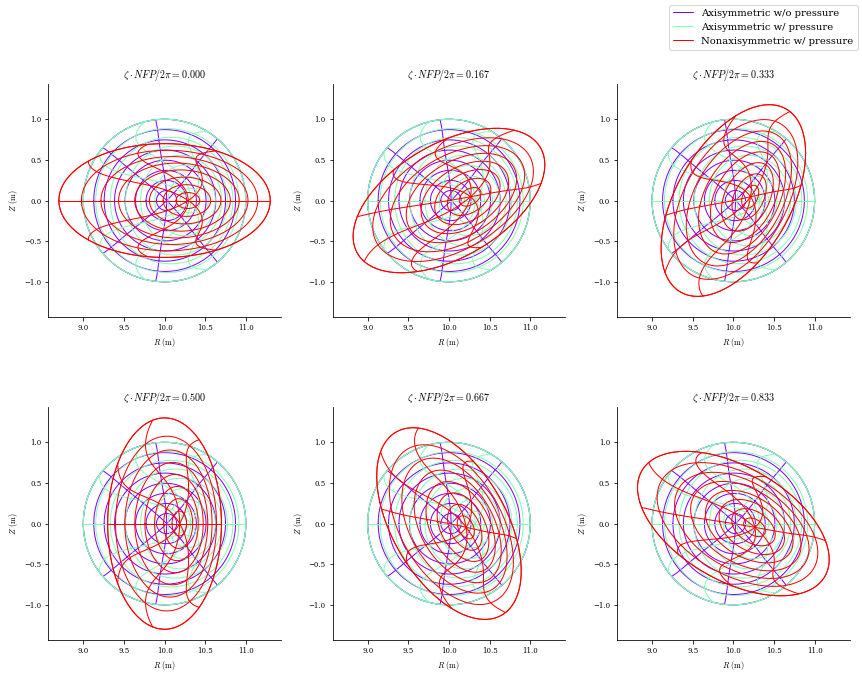

In [5]:
import desc.io
from desc.plotting import plot_section, plot_comparison

eq_fam = desc.io.load('HELIOTRON_continuation_output.h5')
print("Number of equilibria in the EquilibriaFamily:", len(eq_fam))
fig, ax = plot_comparison(eqs=[eq_fam[0],eq_fam[1],eq_fam[2]],labels=['Axisymmetric w/o pressure','Axisymmetric w/ pressure','Nonaxisymmetric w/ pressure'])

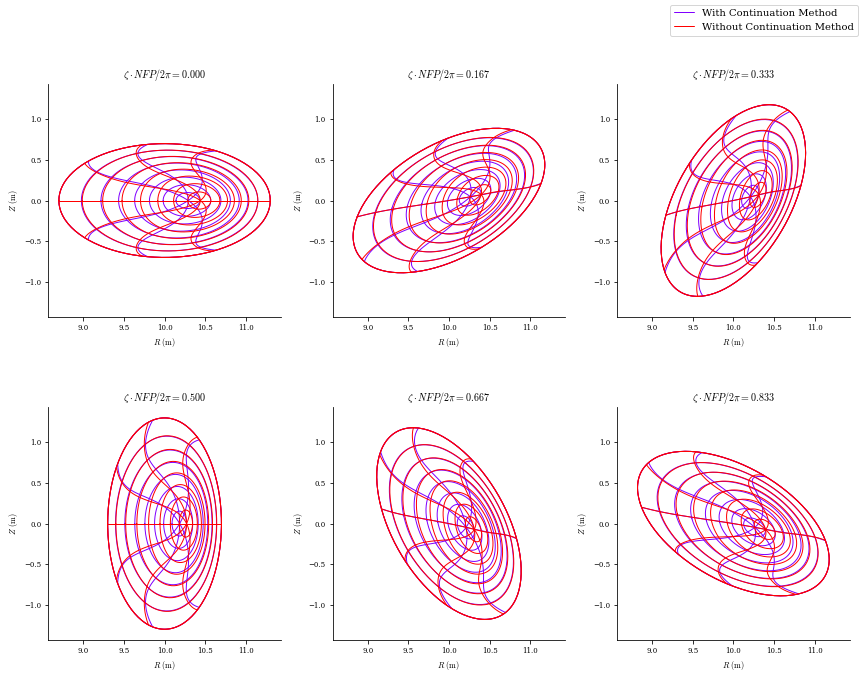

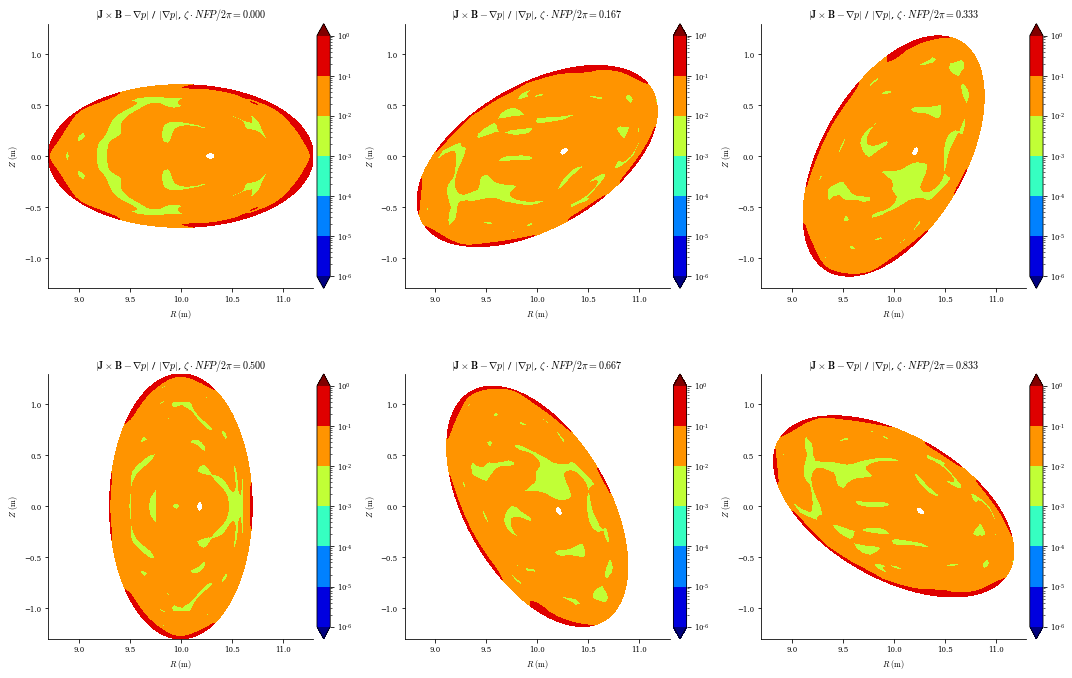

In [7]:
import matplotlib.pyplot as plt
eq_fam_orig = desc.io.load('HELIOTRON_output.h5')

plot_comparison(eqs=[eq_fam[-1],eq_fam_orig[-1]],labels=['With Continuation Method','Without Continuation Method'])
plot_section(eq_fam[-1],name='|F|',log=True,norm_F=True);

And we can also plot the force error for the solution without the continuation method

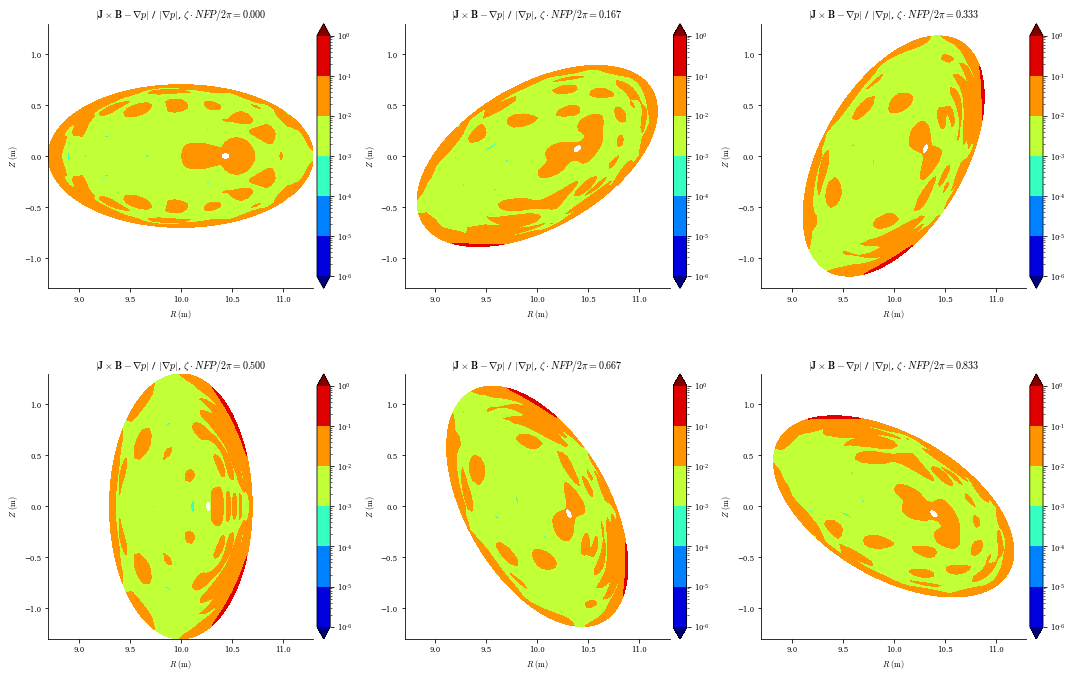

In [8]:
plot_section(eq_fam_orig[-1],'|F|',log=True,norm_F=True);

The solutions appear slightly different by eye, and while the continuation method took a bit longer to run we notice that it also yielded a solution which has lower normalized across the volume by an order of magnitude as compared to the solution found without the continuation method. 

The force error is still relatively high in some parts of the equilibrium (10% when normalized by the pressure gradient), but this is because we are using a relatively low resolution just to showcase the code functionality, and it would decrease if solved with higher resolution.